<a href="https://colab.research.google.com/github/IanWangg/Brain-inspired-scale-invariant-CNN/blob/spectral-density-analysis/Brain_Inspired_Scale_Invariant_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code for implementing scale invariant CNNs.

Here are the results of scale invariance CNNs applied on MNIST. The train images are taken from MNIST directly where as test images are scaled by a factor sampled uniformly from [0.5,2].

```
RESULTS OF MULTISCALE CNN (bilinear)
Train accuracy of the model: 99.160 %
tensor(59497, device='cuda:0') 60000
Test accuracy of the model: 82.702 %
tensor(8271, device='cuda:0') 10000
```

Here are the results of scale invariance CNNs applied on MNIST. The train images are taken from MNIST directly where as test images are scaled by a factor sampled uniformly from [0.5,2.5].

```
RESULTS OF MULTISCALE CNN (bilinear)
Train accuracy of the model: 99.210 %
tensor(59527, device='cuda:0') 60000
Test accuracy of the model: 72.533 %
tensor(7254, device='cuda:0') 10000
```




### Importing required libraries and setting things up

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch

!pip install torchviz

### Rewriting Conv2d to implement the scale invariant convolutions


#### Loading the base class

In [3]:
from torch.nn.modules.utils import _single, _pair, _triple
from torch.nn.modules.conv import *

def _reverse_repeat_tuple(t, n):
    """Reverse the order of `t` and repeat each element for `n` times.
    This can be used to translate padding arg used by Conv and Pooling modules
    to the ones used by `F.pad`.
    """
    return tuple(x for x in reversed(t) for _ in range(n))

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

#### Writing out new convolutional filter. Same number of parameters but convolutions at multiple scales.

In [4]:
#
import random
class Conv2dMultiScale(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros', num_scales=2, pooling_mode='max', level = 1):
        cur_size = kernel_size
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2dMultiScale, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)
        # self.scale = nn.UpsamplingBilinear2d(size=(8,8))
        self.scale = []
        for i in range(num_scales - 1):
          self.scale.append(nn.UpsamplingBilinear2d(size=(cur_size + 2, cur_size + 2)))
        # self.scale = nn.functional.interpolate(size=(5,5), mode='bicubic')
        self.pooling_mode = pooling_mode

    def _conv_forward(self, input, weight_para):
        out1 = F.conv2d(input, weight_para, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        for scale in self.scale:          
          weight = scale(weight_para)
          padding = tuple(x+1 for x in self.padding)
          out2 = F.conv2d(input, weight, self.bias, self.stride,
                        padding, self.dilation, self.groups)
          out2 = F.interpolate(out2, size=out1.shape[2:], mode='bilinear', align_corners=False)         
          if (self.pooling_mode == 'avg'):
            out1 = (out1 + out2)
          elif (self.pooling_mode == 'max'):
            out1 = torch.max(out1, out2)
          else:
            out1 = torch.cat([out1, out2], dim=1)
        if (self.pooling_mode == 'cat'):
          max_pool_results = F.max_pool2d(input, 2)
          max_pool_results = F.interpolate(max_pool_results, size=out1.shape[2:], mode='bilinear', align_corners=False)         
          out1 = torch.cat([out1, max_pool_results], dim=1)
          # print(out1.shape, "--------------------------------------------------------------------")
        return out1

    def forward(self, input):
        return self._conv_forward(input, self.weight)

In [5]:
# Understanding sizes of CNNs, ensuring it works
kernelSize = 5
m = Conv2dMultiScale(1, 64, kernelSize, stride=1, padding=0, num_scales=2, pooling_mode='max')
input = torch.randn(20, 1, 28, 28)
print(input.shape)
output = m(input)
print(output.shape)
output = F.max_pool2d(output, 2)
print(output.shape)
m2 = Conv2dMultiScale(64, 64, kernelSize, stride=1, padding=0, num_scales=3)
output = m2(output)
print(output.shape)
output = F.max_pool2d(output, 2)
print(output.shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 64, 24, 24])
torch.Size([20, 64, 12, 12])
torch.Size([20, 64, 8, 8])
torch.Size([20, 64, 4, 4])


###Train and Test Function

In [6]:
from torchvision import transforms
import random

def train(net, lr=0.001, num_epochs=10, batch_size=64):  
  if torch.cuda.is_available():
    net.cuda()
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam( net.parameters(), lr=lr)

  for epoch in range(num_epochs):
    # scale = random.choice([24, 28, 32])
    for i ,(images,labels) in enumerate(train_gen):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      
      if (i+1) % 100 == 0:
        print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
def test(net):  
  if(net.multiScale):
    print('RESULTS OF MULTISCALE CNN')
  else:
    print('RESULTS OF STANDARD CNN')
  if torch.cuda.is_available():
    net.cuda()
  correct = 0
  total = 0
  # loss_function = nn.CrossEntropyLoss()
  for images,labels in train_gen:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    
    output = net(images)
    # loss = loss_function(outputs, labels)
    _, predicted = torch.max(output,1)
    correct += (predicted == labels).sum()
    total += labels.size(0)
  train_acc = (100*correct.cpu().numpy())/(total+1)
  print('Train accuracy of the model: %.3f %%' %(train_acc))
  print(correct, total)

  correct = 0
  total = 0
  for images,labels in test_gen:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    
    output = net(images)
    # loss = loss_function(outputs, labels)
    _, predicted = torch.max(output,1)
    correct += (predicted == labels).sum()
    total += labels.size(0)
  test_acc = (100*correct.cpu().numpy())/(total+1)
  print('Test accuracy of the model: %.3f %%' %(test_acc))
  print(correct, total)

###Define the Laplacian of Gaussian Kernel

In [7]:
import math
import scipy

def calculate(x, y, sigma):
  return ((x**2 + y**2 - 2 * sigma**2) / sigma**4) * math.exp(-1 * (x**2 + y **2) / 2 * sigma**2)

def create_log_filter(size, sigma):
  matrix = [[0] * size for i in range(size)]
  for i in range(size):
    for j in range(size):
      matrix[i][j] = calculate(i - size // 2, j - size // 2, sigma)
  matrix = torch.Tensor(matrix)
  # print(matrix)
  # print(torch.sum(matrix))
  return matrix

create_log_filter(3, 1)

tensor([[ 0.0000, -0.6065,  0.0000],
        [-0.6065, -2.0000, -0.6065],
        [ 0.0000, -0.6065,  0.0000]])

###Training Data

In [31]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

batch_size=64
scale_train = True
if scale_train:
  train_transform = transforms.Compose([
      transforms.RandomAffine(degrees=0,scale=(1, 1.33)),
      transforms.ToTensor()
  ])
else:
  train_transform = transforms.Compose([
      transforms.ToTensor()
  ])

# test_transform = transforms.Compose([
#     transforms.RandomAffine(degrees=0, scale=(1,1)),
#     transforms.ToTensor(),
# ])

train_data = dsets.CIFAR10(root = './data', train = True,
                        transform = train_transform, download = True)

# test_data = dsets.CIFAR10(root = './data', train = False,
#                        transform = test_transform)

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

# test_gen = torch.utils.data.DataLoader(dataset = test_data,
#                                       batch_size = batch_size, 
#                                       shuffle = False)

Files already downloaded and verified


###Define the Model

In [32]:
log_filter1 = create_log_filter(3, 2)
log_filter2 = create_log_filter(3, 1)

class Net(nn.Module):
    def __init__(self, multiScale=True, cat = False, level_1=3, level_2=2):
        super(Net, self).__init__()
        self.multiScale = multiScale
        self.cat = cat
        self.level_1 = level_1
        self.level_2 = level_2
        if(self.multiScale and not cat):
          self.conv1 = Conv2dMultiScale(3, 64, 5, 1, pooling_mode='max', num_scales=level_1)
          self.conv2 = Conv2dMultiScale(64, 64, 5, 1, pooling_mode='max', num_scales=level_2)
          self.fc = nn.Linear(64 * 5 * 5, 384)
        elif(cat and self.multiScale):
          self.conv1 = Conv2dMultiScale(3, 64, 5, 1, pooling_mode='cat', num_scales=level_1)
          self.conv2 = Conv2dMultiScale(64 * level_1 + 3, 64 * level_1 + 3, 5, 1, pooling_mode='cat', num_scales=level_2)
          self.fc = nn.Linear((64 * level_1 + 3) * 5 * 5 * (level_2 + 1), 384)
        else:
          self.conv1 = nn.Conv2d(3, 64, 5, 1)
          self.conv2 = nn.Conv2d(64, 64, 5, 1)
          self.fc = nn.Linear(64 * 5 * 5, 384)
        self.fc1 = nn.Linear(384, 192)
        self.fc2 = nn.Linear(192, 10)
        self.log1 = nn.Conv2d(3, 3, 3, 1, padding=1)
        self.log2 = nn.Conv2d(self.conv2.weight.shape[0], self.conv2.weight.shape[0], 3, 1, padding=1)
        self.act = F.relu

    def forward(self, x):
        # with torch.no_grad():
        #   self.log1.weight[:][:] = log_filter1
        #   self.log2.weight[:][:] = log_filter2
        # x = self.log1(x)
        x = self.conv1(x)        
        # x = F.relu(x)  
        x = self.act(x)  
        x = F.max_pool2d(x, 2)  
        x = self.conv2(x)       
        # x = F.relu(x)  
        x = self.act(x)     
        x = F.max_pool2d(x, 2)     
        x = torch.flatten(x, 1)       
        x = self.fc(x)
        # x = F.relu(x)   
        x = self.act(x)    
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.act(x) 
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        # else: 
        return output


net = Net(multiScale=True, cat=False)
# print(net.conv2.weight.shape[0])
# x = torch.randn(10, 3, 32, 32)
# x = net.log1(x)
# x.shape
# with torch.no_grad():
#     net.conv1.weight[:][:] = x
# net.conv1.weight

###Train, Test and Results

In [33]:
train(net, lr=0.0005, num_epochs=5)
train(net, lr=0.001, num_epochs=10)
train(net, lr=0.0005, num_epochs=5)
# train(net, lr=0.001, num_epochs=20)

Epoch [1/5], Step [100/781], Loss: 2.0882
Epoch [1/5], Step [200/781], Loss: 1.7812
Epoch [1/5], Step [300/781], Loss: 1.4443
Epoch [1/5], Step [400/781], Loss: 1.7271
Epoch [1/5], Step [500/781], Loss: 1.4955
Epoch [1/5], Step [600/781], Loss: 1.6050
Epoch [1/5], Step [700/781], Loss: 1.4873
Epoch [2/5], Step [100/781], Loss: 1.3405
Epoch [2/5], Step [200/781], Loss: 1.3989
Epoch [2/5], Step [300/781], Loss: 1.3781
Epoch [2/5], Step [400/781], Loss: 1.3542
Epoch [2/5], Step [500/781], Loss: 1.5288
Epoch [2/5], Step [600/781], Loss: 1.1357
Epoch [2/5], Step [700/781], Loss: 1.4184
Epoch [3/5], Step [100/781], Loss: 1.2619
Epoch [3/5], Step [200/781], Loss: 1.2268
Epoch [3/5], Step [300/781], Loss: 1.3900
Epoch [3/5], Step [400/781], Loss: 1.3050
Epoch [3/5], Step [500/781], Loss: 0.9134
Epoch [3/5], Step [600/781], Loss: 1.1470
Epoch [3/5], Step [700/781], Loss: 1.1648
Epoch [4/5], Step [100/781], Loss: 1.0464
Epoch [4/5], Step [200/781], Loss: 1.0466
Epoch [4/5], Step [300/781], Loss:

###Fourier Analysis of Kernels


In [10]:
# for name, named_para in net.named_parameters():
#   if named_para.requires_grad:
#     print(named_para.name, named_para.shape)

for name, param in net.named_parameters():
  if param.requires_grad:
      print(name, param.shape)

conv1.weight torch.Size([64, 3, 5, 5])
conv1.bias torch.Size([64])
conv2.weight torch.Size([64, 64, 5, 5])
conv2.bias torch.Size([64])
fc.weight torch.Size([384, 1600])
fc.bias torch.Size([384])
fc1.weight torch.Size([192, 384])
fc1.bias torch.Size([192])
fc2.weight torch.Size([10, 192])
fc2.bias torch.Size([10])
log1.weight torch.Size([3, 3, 3, 3])
log1.bias torch.Size([3])
log2.weight torch.Size([64, 64, 3, 3])
log2.bias torch.Size([64])


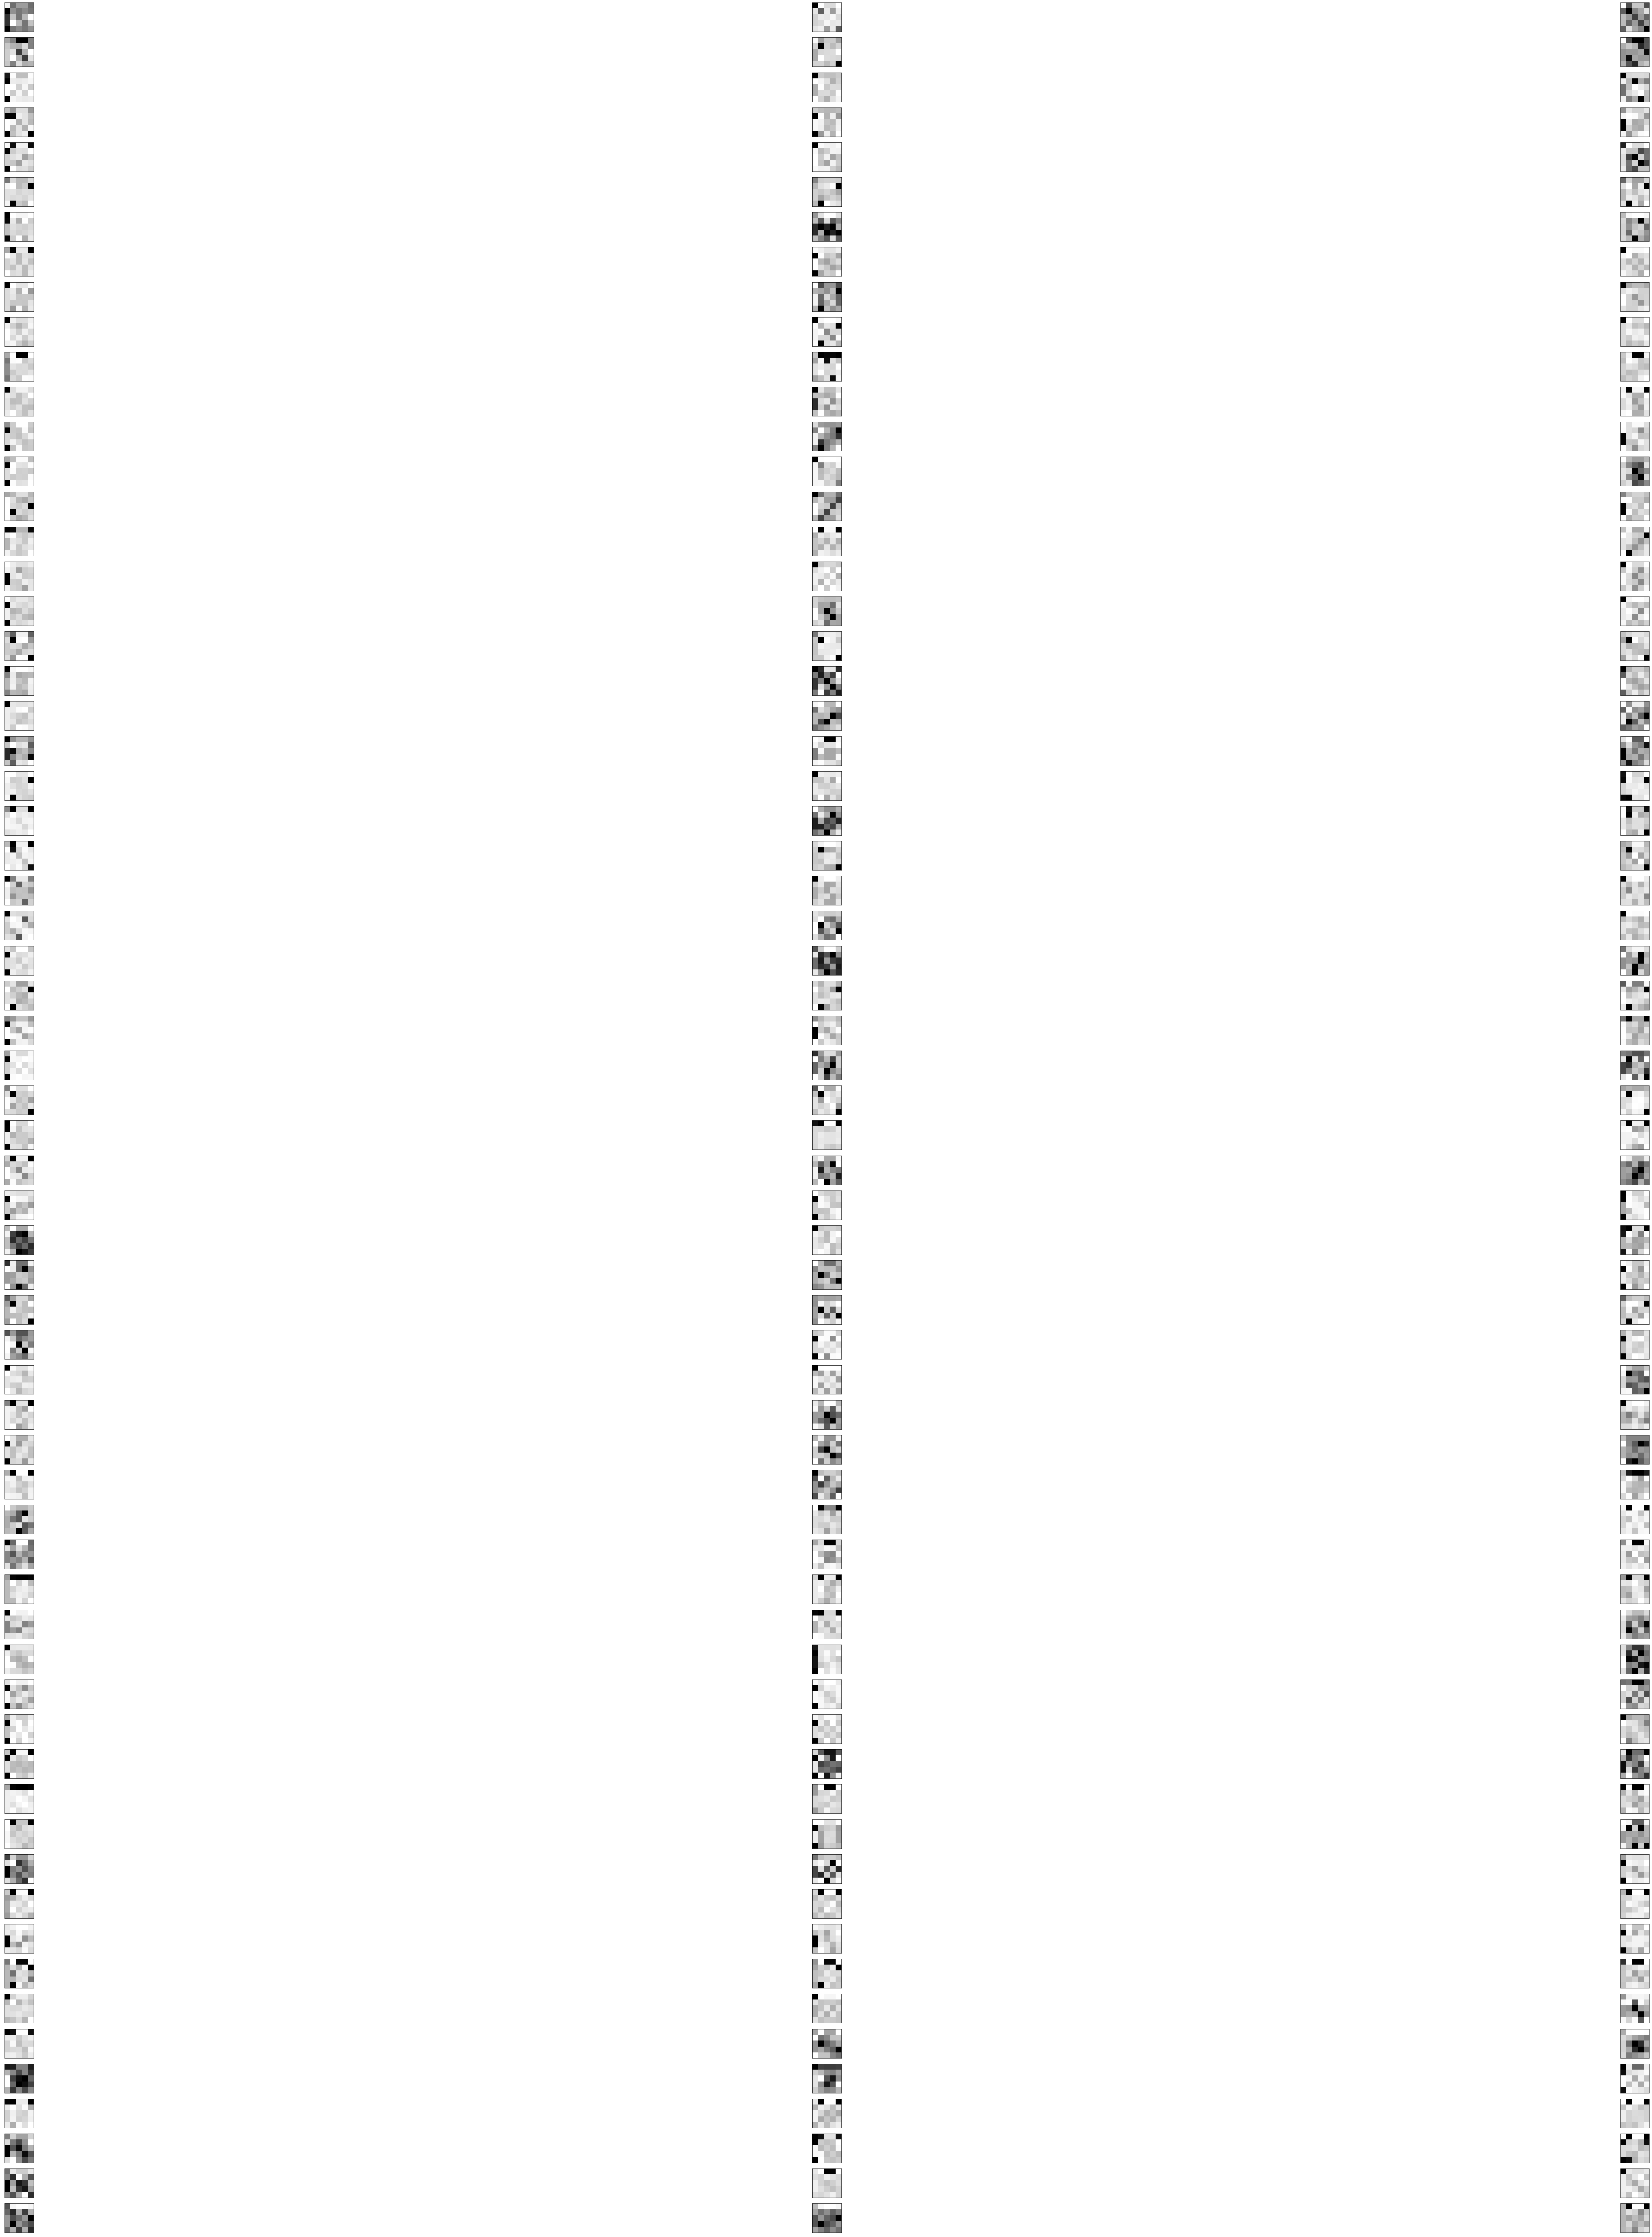

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
import pylab as py
from math import pi
import scipy as sp
from scipy import signal

# def fourier(kernel):
#     F1 = fftpack.fft2(kernel)
#     F2 = fftpack.fftshift(F1)
#     return F2

# def showFourier(kernel):
#     psd2D = np.log(np.abs(fourier(kernel))**2+1)
#     (height,width) = psd2D.shape
#     py.figure(figsize=(10,10*height/width),facecolor='white')
#     py.clf()
#     py.rc('text',usetex=True)
#     py.xlabel(r'$\omega_1$',fontsize=24)
#     py.ylabel(r'$\omega_2$',fontsize=24)
#     py.xticks(fontsize=16)
#     py.yticks(fontsize=16)
#     py.imshow( psd2D, cmap='Greys_r',extent=[-pi,pi,-pi,pi],aspect='auto')
#     py.show()


def show_psd(weights):
  index = 1
  inchannel = weights.shape[1]
  outchannel = weights.shape[0]
  plt.figure(figsize=(100, 100))
  for i in range(outchannel):
    filter = weights[i, :, :, :]
    for j in range(inchannel):
      ax = plt.subplot(outchannel, inchannel, index)
      ax.set_xticks([])
      ax.set_yticks([])
      spectra = np.fft.fft2(filter[j, :, :])
      spectra = 20*np.log(np.abs(spectra)**2)
      spectra = np.asarray(spectra, dtype=np.uint8)
      # print(spectra)
      plt.imshow(spectra, cmap='gray')
      index += 1
  plt.show()

weights = Tensor.cpu(net.conv1.weight).data.numpy()
show_psd(weights)




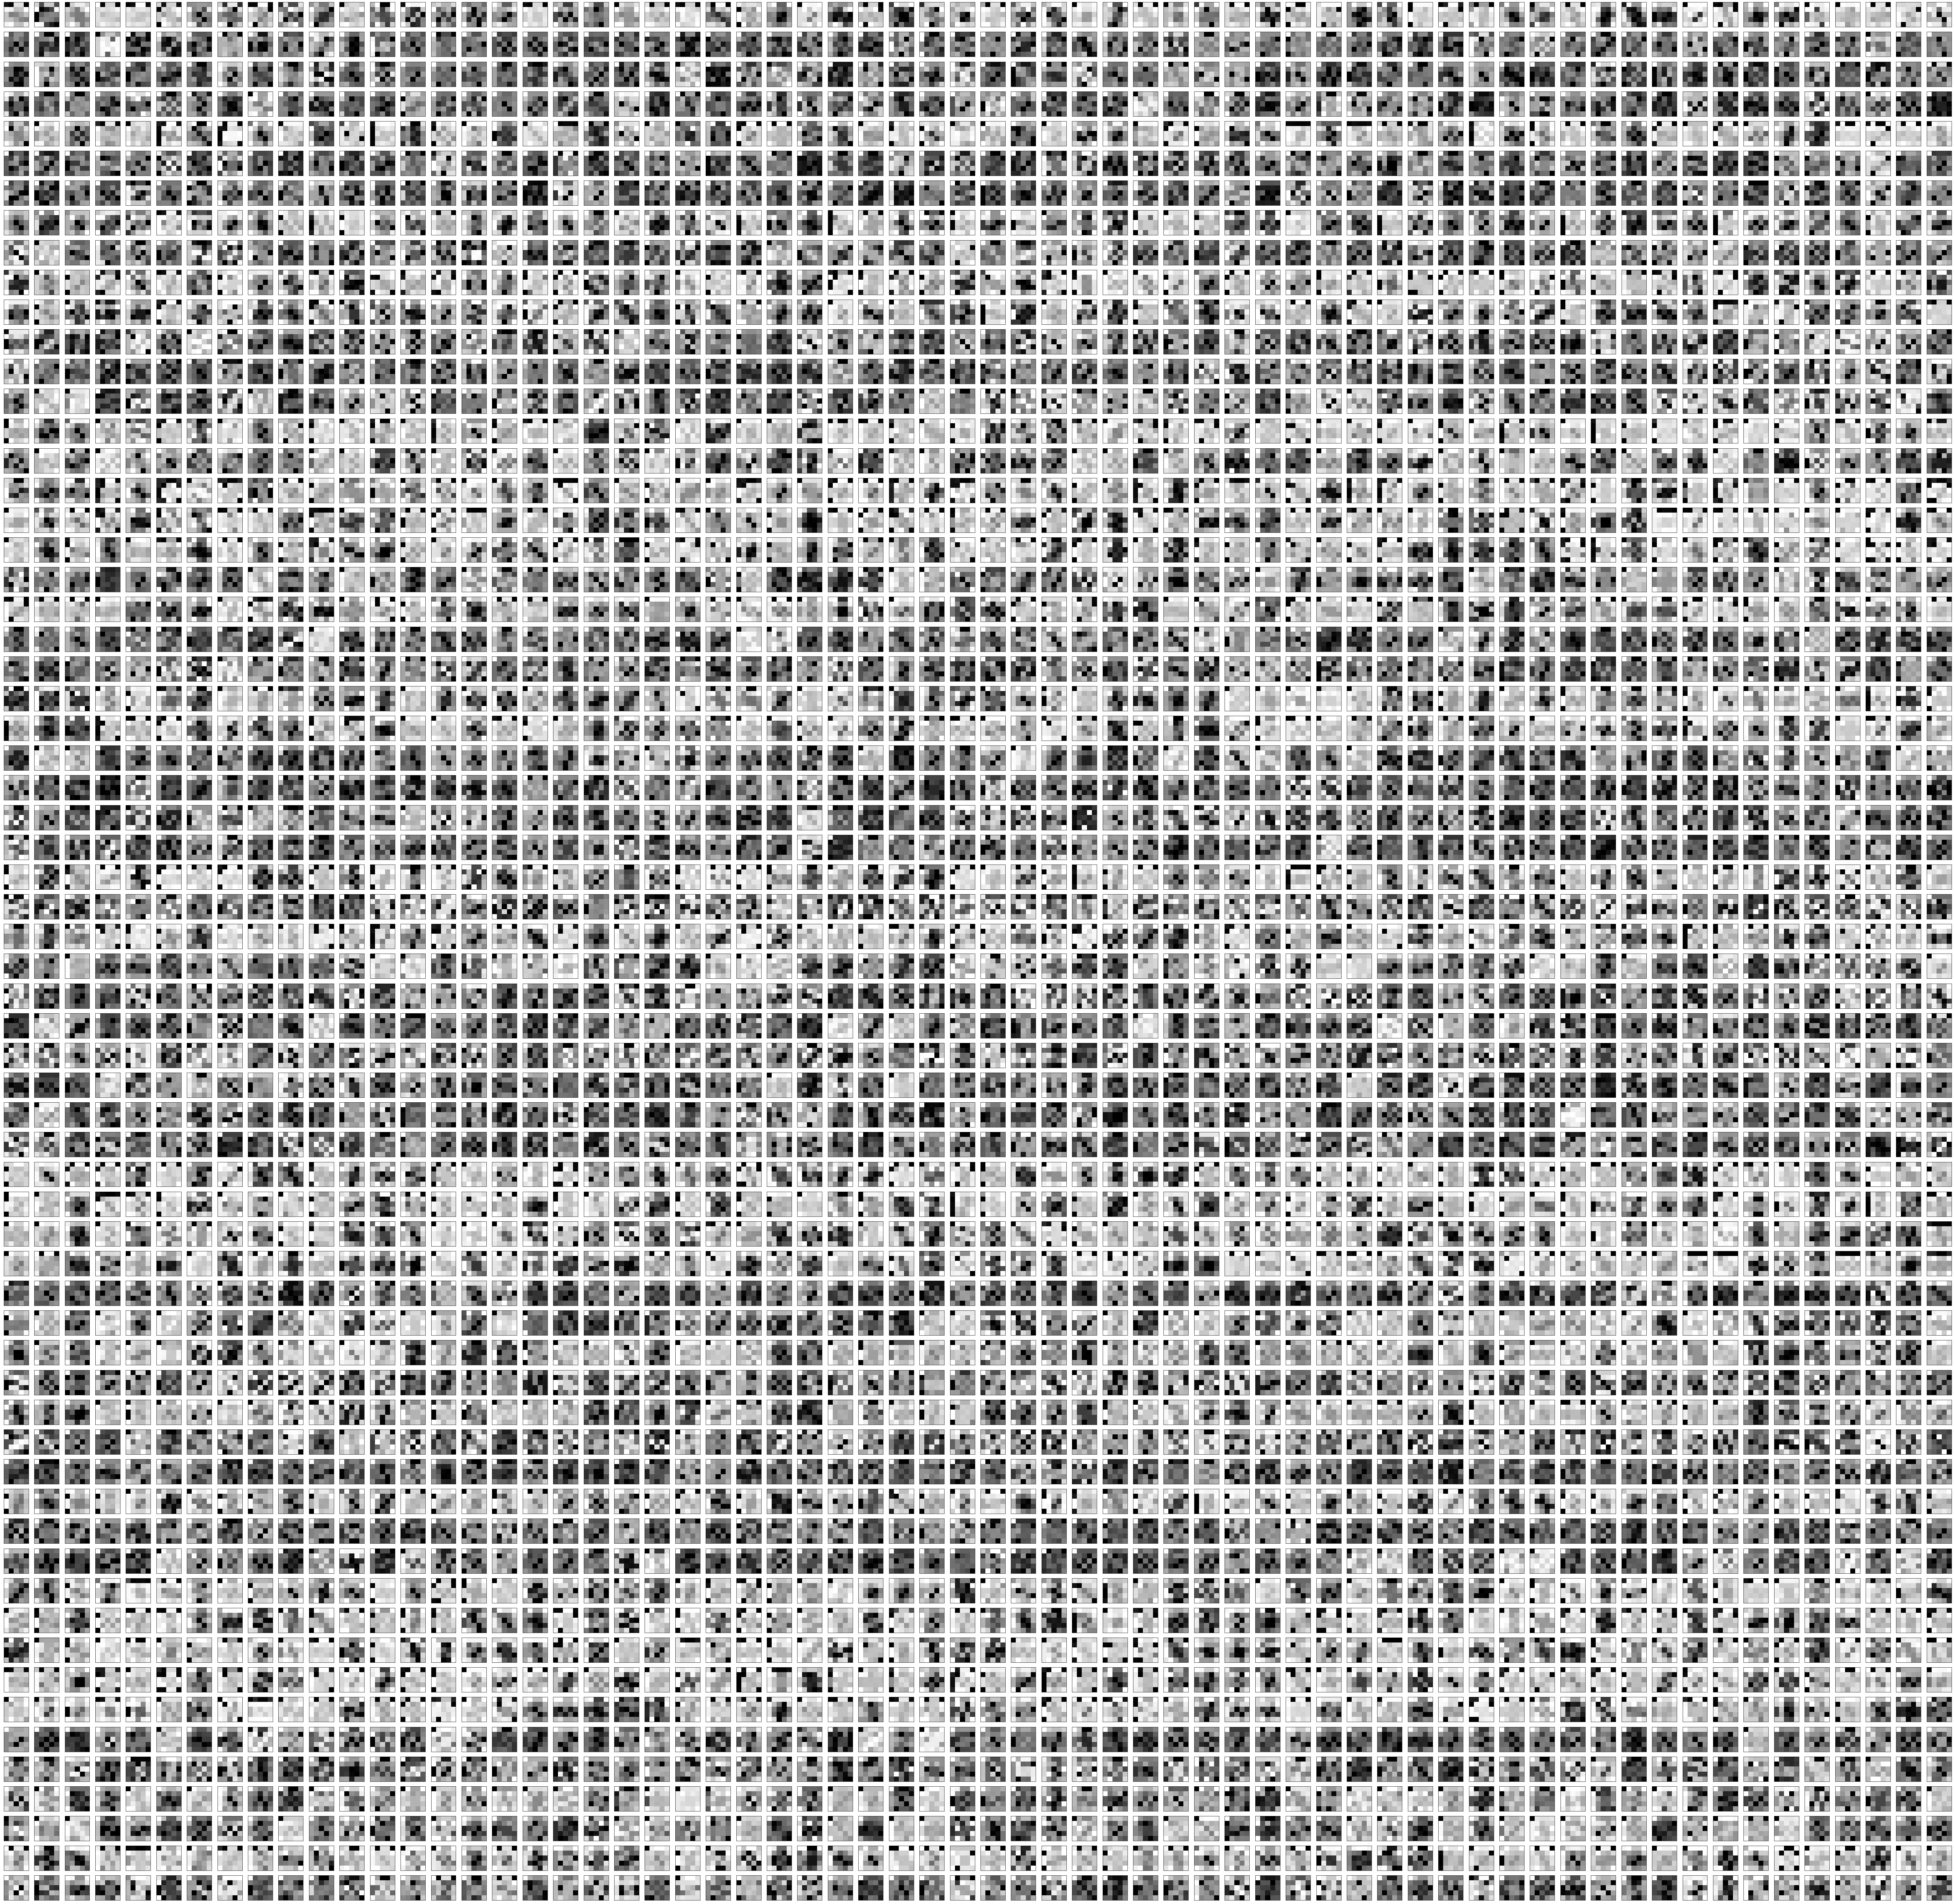

In [35]:
weights = Tensor.cpu(net.conv2.weight).data.numpy()
show_psd(weights)

###Test on CIFAR-10

###32 -> 32

In [36]:
test_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(1,1.33)),
    transforms.Resize(32, interpolation=2),
    transforms.ToTensor(),
])

test_data = dsets.CIFAR10(root = './data', train = False,
                       transform = test_transform, download=True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)
print("Scaled_Train: ", scale_train)
print("Architecture:\n","num_scale:",net.level_1,",",net.level_2,"\nnet.Multiscale=",net.multiScale,"\ncat=",net.cat)
test(net)

Files already downloaded and verified
Scaled_Train:  True
Architecture:
 num_scale: 3 , 2 
net.Multiscale= True 
cat= False
RESULTS OF MULTISCALE CNN
Train accuracy of the model: 88.612 %
tensor(44307, device='cuda:0') 50000
Test accuracy of the model: 69.283 %
tensor(6929, device='cuda:0') 10000


###32 -> 28

In [ ]:
test_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(1,1.33)),
    transforms.Resize(32, interpolation=2),
    transforms.ToTensor(),
])

test_data = dsets.CIFAR10(root = './data', train = False,
                       transform = test_transform, download=True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)
print("Scaled_Train: ", scale_train)
print("Architecture:\n","num_scale:",net.level_1,",",net.level_2,"\nnet.Multiscale=",net.multiScale,"\ncat=",net.cat)
test(net)

NameError: ignored

###32 -> 24

In [ ]:
test_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(1,1.33)),
    transforms.Resize(32, interpolation=2),
    transforms.ToTensor(),
])

test_data = dsets.CIFAR10(root = './data', train = False,
                       transform = test_transform, download=True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)
print("Scaled_Train: ", scale_train)
print("Architecture:\n","num_scale:",net.level_1,",",net.level_2,"\nnet.Multiscale=",net.multiScale,"\ncat=",net.cat)
test(net)

Files already downloaded and verified
Architecture:
 num_scale: 3 , 2 
net.Multiscale= True 
cat= False
RESULTS OF MULTISCALE CNN
Train accuracy of the model: 99.586 %
tensor(49794, device='cuda:0') 50000
Test accuracy of the model: 52.705 %
tensor(5271, device='cuda:0') 10000
